# Imports
Imports required libraries

In [1]:
from __future__ import print_function, division
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn as sklearn
from datetime import datetime
from sklearn.calibration import calibration_curve
from sklearn.cross_validation import train_test_split, KFold, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, roc_curve
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.svm import LinearSVC, SVC
from numpy import random
import sqlite3
%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1) Description of the dataset
The initial database has four tables: Countries, leagues, teams, team_atts, matches, players, player_atts.

Countries - The country_id for each match (which country the match took place in)

Leagues - The league_id for each match (as each country only has one league in this set, this is identical to country_id and not needed).

Teams - Contains the id, team_api_id, team_fifa_api_id, and name of each team. The team_fifa_api_id is what the id of each team is in the FIFA games (where player/team statistics are pulled from).

Team_atts - Contains attributes about each team: their playstyle, offense, defense, etc.

Matches - This contains the bulk of the data that we want. Contains information about: who the home/away team are, which league the game took place in, which season, the data, player statistics, and betting data.

Players - Contains information about each player: their id, age, team, stature

Player_atts - Has information on the attributes of each player: their skills, strengths, weaknesses, but most importantly their player rating.

--A side note, teams and players contain both a FIFA and non-FIFA key. Matches are joined to them by non-FIFA key.--

We will now read-in the tables from the sqlite database.

In [2]:
with sqlite3.connect('database.sqlite') as con:
    all_countries = pd.read_sql_query("SELECT * from Country", con)
    all_matches = pd.read_sql_query("SELECT * from Match", con)
    players = pd.read_sql_query("SELECT * from Player", con)
    player_atts = pd.read_sql_query("SELECT * from Player_Attributes", con)
    team_atts = pd.read_sql_query("SELECT * from Team_Attributes", con)
    all_teams = pd.read_sql_query("SELECT * from Team", con)


For now, we will currently only be examining betting data from bet365. Many of the betting sites included in the dataset are missing betting data on a large portion of the matches and bet365 has by far the most.

We will also drop attributes that will not be useful for what we want yet; these attributes are generally ingame statistics of the matches in general.

`league_id` is also dropped because we are not using the leagues table.

In [3]:
# Drops unneeded attributes
atts_to_drop = ['BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'GBD',
               'PSH', 'PSD', 'PSA', 'WHH', 'WHA', 'WHD', 'SJH', 'SJD', 'SJA', 'VCH',
               'VCD', 'VCA', 'GBH', 'GBA', 'BSH', 'BSD', 'BSA', 'shoton', 'goal', 'shotoff',
               'foulcommit', 'card', 'cross', 'corner', 'possession', 'league_id']
all_matches = all_matches.drop(atts_to_drop, axis=1) 
# Drops player formation values
all_matches = all_matches.drop(all_matches.columns[10:54], axis=1)

# Drops null values
all_matches = all_matches.dropna()
players = players.dropna()
player_atts = player_atts.dropna(subset = ['date', 'overall_rating', 'player_api_id'], axis = 0)
team_atts = team_atts.dropna()



Convert dates into datetime objects

In [4]:
all_matches['date'] = all_matches['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %X'))
player_atts['date'] = player_atts['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %X'))

We will now replace `home_player_*` and `away_player_*` (player IDs) with their player ratings.

In [5]:
h_a_players = ['home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5',
          'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
          'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6',
          'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11']

def process_row(row):
    all_matches.loc[row.name, h_a_players] = row[h_a_players].map(lambda x: find_rating_by_date(player_atts.loc[(player_atts['player_api_id'] == x)], row['date']))
def find_rating_by_date(rows, date):
    nearest_date = nearest(rows['date'], date) #The date we will use for the player ratings
    n = rows.loc[rows['date'] == nearest_date]['overall_rating']
    return rows.loc[rows['date'] == nearest_date]['overall_rating']
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x-pivot))
all_matches.apply(lambda x: process_row(x), axis = 1)
all_matches.head(5)

,id,country_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A
145,146,1,2008/2009,24,2009-02-27,493017,8203,9987,2,1,...,54.0,72.0,67.0,65.0,70.0,68.0,63.0,3.00,3.4,2.30
153,154,1,2008/2009,25,2009-03-08,493025,9984,8342,1,3,...,66.0,70.0,69.0,68.0,67.0,73.0,68.0,2.80,3.2,2.37
155,156,1,2008/2009,25,2009-03-07,493027,8635,10000,2,0,...,49.0,64.0,69.0,66.0,55.0,58.0,64.0,1.40,4.5,8.00
162,163,1,2008/2009,26,2009-03-13,493034,8203,8635,2,1,...,67.0,75.0,70.0,77.0,74.0,70.0,69.0,4.50,3.6,1.75
168,169,1,2008/2009,26,2009-03-14,493040,10000,9999,0,0,...,60.0,58.0,65.0,60.0,60.0,63.0,65.0,1.75,3.5,4.75


Now, convert home_team_api_id and away_team_api_id to their team names.

In [6]:
all_matches['home_team_api_id'] = all_matches['home_team_api_id'].map(all_teams.set_index('team_api_id')['team_long_name'])
all_matches['away_team_api_id'] = all_matches['away_team_api_id'].map(all_teams.set_index('team_api_id')['team_long_name'])

Now we are going to add a new column, `match_result` which compares `home_team_goal` and `away_team_goal` and determines who won, or if there was a tie.

In [7]:
# Replace home_team_goal and away_team_goal with home_win (0 = no/draw, 1 = yes)
def find_winner(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 2
    if row['home_team_goal'] == row['away_team_goal']: 
        return 1
    if row['home_team_goal'] < row['away_team_goal']:
        return 0
all_matches.insert(9, 'match_result', -1)
all_matches['match_result'] = all_matches.apply(lambda x: find_winner(x), axis = 1)
all_matches = all_matches.drop(['home_team_goal', 'away_team_goal'], axis = 1)

Now, we find the country codes for each country. This will be uesful for later in joining the separate tables.

In [8]:
country_codes = {'England' : 1729, 
                  'France' : 4769, 
                  'Germany' : 7809, 
                  'Italy' : 10257, 
                  'Netherlands' : 13274, 
                  'Spain' : 21518}

# 3) Selecting a Model to Predict Wins
We will now use a dummy baseline classifier to serve as baseline scores for models we will create. We will be creating dictionaries to store the different classifiers (one for each nation).

In [10]:
unneeded_atts = ['match_result', 'date', 'season', 'B365H', 'B365A', 'B365D', 'match_result',
                                 'country_id', 'id', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'stage']
all_country_matches = {}
y_trs = {}
X_trs = {}
X_vals = {}
y_vals = {}

for country, country_id in country_codes.items():
    all_country_matches[country] = all_matches[(all_matches['country_id'] == country_id)]

for country, all_matches in all_country_matches.items():
    X = all_matches.drop(unneeded_atts, axis=1)
    y = all_matches['match_result']
    X_trs[country], X_vals[country], y_trs[country], y_vals[country] = train_test_split(X, y, test_size = 0.2, random_state = 0)

for country in country_codes.keys():
    X_tr = X_trs[country]
    y_tr = y_trs[country]
    X_val = X_vals[country]
    y_val = y_vals[country]
    dc = DummyClassifier(strategy = 'most_frequent')
    dc.fit(X_tr, y_tr)
    print("Baseline classification accuracy of %s matches: %f" % (country, dc.score(X_val, y_val)))



Baseline classification accuracy of England matches: 0.458685
Baseline classification accuracy of France matches: 0.436300
Baseline classification accuracy of Germany matches: 0.458947
Baseline classification accuracy of Italy matches: 0.473588
Baseline classification accuracy of Netherlands matches: 0.422604
Baseline classification accuracy of Spain matches: 0.492620


In [11]:
k_folds = {}
for country in country_codes.keys():
    k_folds[country] = KFold(X_trs[country].index.size, n_folds = 10, shuffle = True, random_state = 0)

lgr_models = {}
c_space = np.logspace(-5, 5, 20)
for country in country_codes.keys():
    X_tr = X_trs[country]
    y_tr = y_trs[country]
    X_val = X_vals[country]
    y_val = y_vals[country]
    lgr_models[country] = LogisticRegressionCV(Cs = c_space, cv = k_folds[country], solver = 'newton-cg', multi_class = 'multinomial')
    lgr_models[country].fit(X_tr, y_tr)
    print("Classification accuracy of Nonlinear Conjugate Gradient Regression on %s matches: %f" % (country, lgr_models[country].score(X_val, y_val)))

/usr/local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Classification accuracy of Nonlinear Conjugate Gradient Regression on England matches: 0.519393
Classification accuracy of Nonlinear Conjugate Gradient Regression on France matches: 0.478185
Classification accuracy of Nonlinear Conjugate Gradient Regression on Germany matches: 0.532632
Classification accuracy of Nonlinear Conjugate Gradient Regression on Italy matches: 0.537341
Classification accuracy of Nonlinear Conjugate Gradient Regression on Netherlands matches: 0.560197
Classification accuracy of Nonlinear Conjugate Gradient Regression on Spain matches: 0.527675


Not bad, we've gotten a fairly decent increase in classification accuracy compared to the baseline classifier. Logistic regression is actually one of the most commonly used models for predicting competition outcomes, and thus these results are expected. I decided to use nonlinear conjugate gradient regression (`newton-cg`) as it supports multinomial regression (needed as there are three potential outcomes, not just two). 

Let's see if we can do better. I will now create a RandomForestClassifier, see its scores, and then see what the most impactful features are.

In [12]:
for country in country_codes.keys():
    X_tr = X_trs[country]
    y_tr = y_trs[country]
    X_val = X_vals[country]
    y_val = y_vals[country]
    rfc = RandomForestClassifier(n_estimators = 29, random_state = 31)
    rfc.fit(X_tr, y_tr)
    print("Random Forest classification accuracy of %s matches: %f" % (country, rfc.score(X_val, y_val)))

Random Forest classification accuracy of England matches: 0.490725
Random Forest classification accuracy of France matches: 0.464223
Random Forest classification accuracy of Germany matches: 0.482105
Random Forest classification accuracy of Italy matches: 0.484517
Random Forest classification accuracy of Netherlands matches: 0.528256
Random Forest classification accuracy of Spain matches: 0.522140


Random forest generally doesn't perform as well as logistic regression does. The only score that sees a (marginal) improvement is the classification of Dutch matches; it might be worthwhile to explore why this is the case in the future. 
Parameter tuning also must be taken into account when trying to create random forest models; this too should be explored in the future.

In [13]:
rfc_sample = RandomForestClassifier(n_estimators = 29, random_state = 31).fit(X_trs["England"], y_trs["England"])
def find_feature_name_england(n):
    index = all_features.index(n)
    return X_trs["England"].columns.values[index]
all_features = list(rfc_sample.feature_importances_)
top_50_features = np.sort(rfc_sample.feature_importances_)[::-1][:50]
find_feature_name = np.vectorize(find_feature_name_england)
find_feature_name(top_50_features)


array(['home_player_9', 'home_player_8', 'away_player_4', 'away_player_7',
       'home_player_6', 'away_player_8', 'home_player_7', 'away_player_5',
       'away_player_11', 'home_player_10', 'away_player_1',
       'home_player_4', 'home_player_11', 'away_player_6', 'away_player_3',
       'away_player_10', 'away_player_9', 'home_player_5', 'home_player_3',
       'home_player_1', 'away_player_2', 'home_player_2'],
      dtype='<U14')

It's very interesting to note that the least important features (top_50_features in this case) are all related to players. Originally, I thought that the players would likely be the most important features. However, we can recap a few conclusions from the above results. It seems that the Spanish leagues are generally easier to predict than every other league. This could be because of many reasons:

i) Certain teams that always win against other teams

ii) Very top-heavy league

iii) Low variance

(note, these three factors are not necessarily independent of eachother).

In [14]:
for country in country_codes:
    rbf = SVC(kernel = 'rbf', probability = True)
    rbf_score = np.mean(cross_val_score(rbf, X_trs[country], y_trs[country], cv = k_folds[country]))
    print("Classification accuracy of RBF SVC on %s matches: %f" % (country, rbf_score))

Classification accuracy of RBF SVC on England matches: 0.454615
Classification accuracy of RBF SVC on France matches: 0.452827
Classification accuracy of RBF SVC on Germany matches: 0.452632
Classification accuracy of RBF SVC on Italy matches: 0.463493
Classification accuracy of RBF SVC on Netherlands matches: 0.486132
Classification accuracy of RBF SVC on Spain matches: 0.482902


RBF-kernel SVCs perform worse than logistic regression, and actually even worse than the baseline estimator does.
It is clear that the best model to use is Logistic Regression currently.

# 4) Individual Team Predictions

I will be using the Spanish League currently in this example. I will use the Spanish logistic regression model I trained above. I will then visualize the results, and hopefully be able to apply it to every team from the leagues we've chosen.

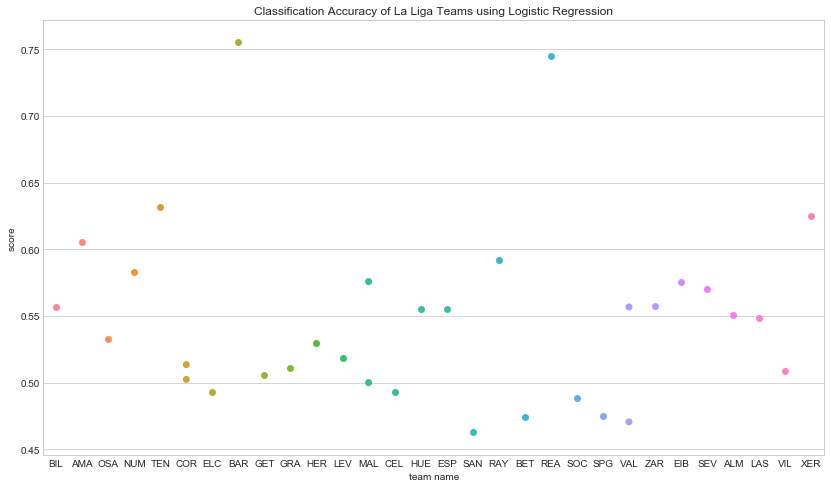

In [16]:
spain_matches = all_country_matches['Spain']
spanish_teams = spain_matches['home_team_api_id'].unique()
spanish_teams = spanish_teams.astype('U')
spanish_results = {}
spanish_match_predictions = {}
# For every spanish team, return the score of an lbfgs-logistic regression model on predicting their results.
for team in spanish_teams:
    team_matches = spain_matches.loc[(spain_matches['home_team_api_id'] == team) | (spain_matches['away_team_api_id'] == team)]
    X_team = team_matches.drop(unneeded_atts, axis = 1)
    y_team = team_matches['match_result']
    team_score = lgr_models['Spain'].score(X_team, y_team)
    spanish_match_predictions[team] = lgr_models['Spain'].predict(X_team)
    spanish_results[team] = team_score

# Separate score results by team
spanish_results = pd.Series(spanish_results, name = 'score')
spanish_results.index.name = 'team'
spanish_results = spanish_results.reset_index()
team_name_map = all_teams[['team_long_name', 'team_short_name']].set_index('team_long_name')['team_short_name'].to_dict()
spanish_results['team_short'] = spanish_results['team'].map(team_name_map)

# Display scatter plot data
sns.set_style('whitegrid')
plt.figure(figsize = [14, 8])
plt.title('Classification Accuracy of La Liga Teams using Logistic Regression')
g = sns.stripplot(x="team_short", y="score", data=spanish_results, size = 7)
plt.xlabel('team name')


Interesting! BAR (FC Barcelona) and REA (Real Madrid) are far and away the most accurately predicted teams. This is notable, as Barcelona and Real Madrid are two of the most dominant teams in the league (the Spanish league is infamously top-heavy, primarily with these two teams). Thus, there seems to be a pretty strong correlation between a team's success and the classification accuracy?

I will now plot the confusion matrix of the predictions of the linear regression model against the actual results. Perhaps this may lend more insight into why this correlation is the case?

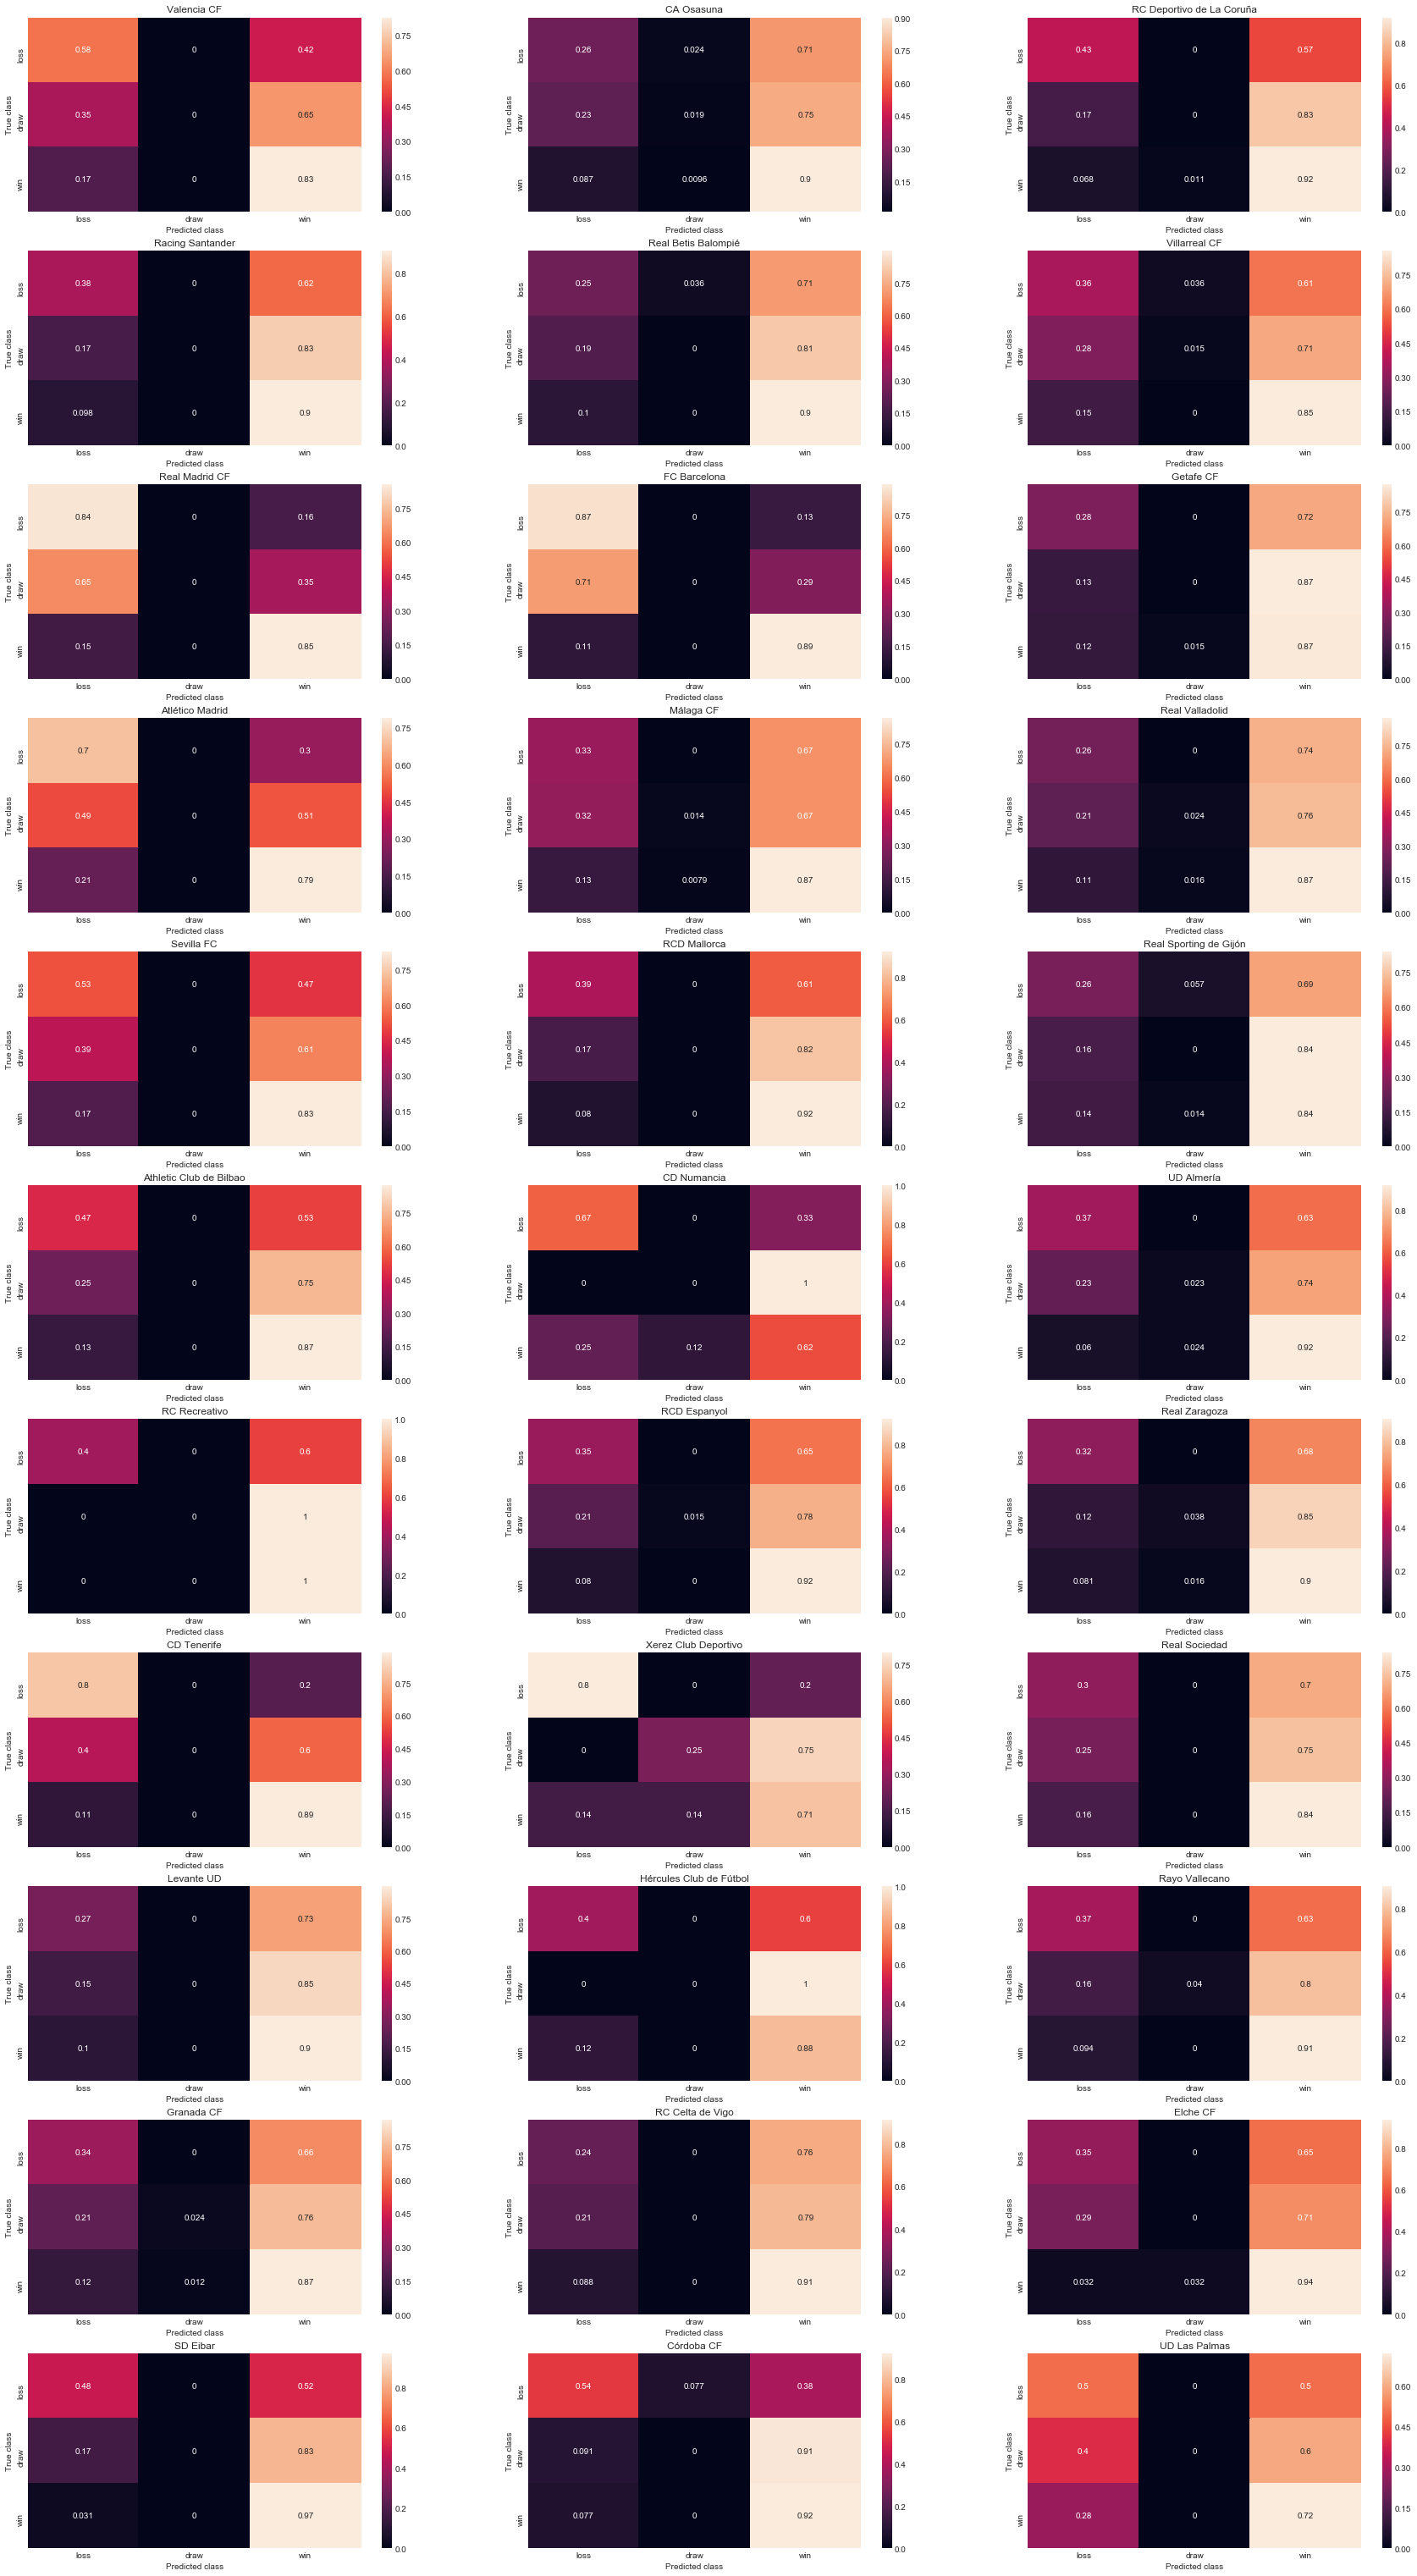

In [221]:
f = plt.figure(figsize=(30, 55))
counter = 0
for team in spanish_teams:
    team_results = spain_matches.loc[(spain_matches['home_team_api_id'] == team) | (spain_matches['away_team_api_id'] == team)]['match_result']
    cnf_matrix = confusion_matrix(team_results, spanish_match_predictions[team])
    cnf_matrix = cnf_matrix.astype('float')
    cnf_matrix = sklearn.preprocessing.normalize(cnf_matrix, norm = 'l1', axis = 1)
    sub = f.add_subplot(np.ceil(int(len(spanish_teams)/3)), 3, counter + 1)
    counter = counter + 1
    sns.heatmap(cnf_matrix, annot = True, xticklabels = ['loss', 'draw', 'win'], yticklabels = ['loss', 'draw', 'win'])
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.title(team)

plt.show()

There doesn't seem to be any discernible trends aside from the fact that the model absolutely hates predicting draws.

In [27]:
team_sets = []
for country in country_codes.keys():
    team_sets.append((country, all_country_matches[country], lgr_models[country], {}))

for country, country_matches, lgr, results in team_sets:
    team_apis = country_matches['home_team_api_id'].unique()
    team_apis = team_apis.astype('U')
    for team in team_apis:
        team_matches = country_matches.loc[country_matches['home_team_api_id'] == team]
        team_matches = team_matches.append(country_matches.loc[country_matches['away_team_api_id'] == team])
        X_team = team_matches.drop(unneeded_atts, axis = 1)
        y_team = team_matches['match_result']
        team_score = lgr.score(X_team, y_team)
        results[team] = team_score


In [28]:
all_results = pd.DataFrame(columns = ['team','score','country'])
all_results = all_results.fillna(0)
for country, c_matches, lgr, results in team_sets:
    results = pd.DataFrame({'team' : list(results.keys()), 'score': list(results.values())})
    results['country'] = country
    all_results = all_results.append(results)

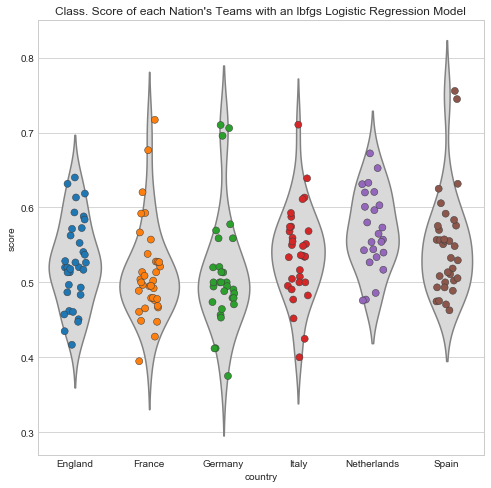

In [29]:
sns.set_style('whitegrid')
plt.figure(figsize = [8, 8])
plt.title('Class. Score of each Nation\'s Teams with an lbfgs Logistic Regression Model')
ax = sns.violinplot(x="country", y="score", data=all_results, inner=None, color=".85")
ax= sns.stripplot(x="country", y="score", data=all_results, size = 7, jitter = .15, linewidth = .5)
plt.xlabel('country')


I think it's really interesting how the distribution of classification accuracies for each team/league fairly accurately reflects popular opinion! The Spanish league is seen as very top heavy with two highly elite teams; the same applies to France and Germany (although there seems to be a third team in Germany near the top of classification accuracies).

The Premier League (English league) is seen as one of the toughest and most even leagues, and this is reflected with every team being fairly close to eachother (relative to the other leagues atleast). Even then, you can clearly see the famous four best teams of the Premier League (Chelsea, Manchester United, Manchester City, and Arsenal I'm assuming.. the dataset is from recent years only and Liverpool hasn't been performing as well as they have historically).

One thing that's very interesting to note is the relative 'ease' there is in predicting matches in the Dutch league.. They had the lowest baseline score (~0.422), but had by far the highest classification accuracy in logistic regression (~0.560).